In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [3]:
# Load dataset
train_dataset = ImageFolder(root=r"D:\PlantDIsease\PDMD - RFS70\train", transform=transform)
val_dataset = ImageFolder(root=r"D:\PlantDIsease\PDMD - RFS70\val", transform=transform)
test_dataset = ImageFolder(root=r"D:\PlantDIsease\PDMD - RFS70\test", transform=transform)

In [4]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# efficientnet_b0(weights="DEFAULT")

# Define EfficientNet model
model = models.efficientnet_b0(pretrained=True)

C:\Users\Welcome\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Welcome\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Display model summary
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
# Transfer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
# Define loss function with label smoothing
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = torch.nn.functional.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * \
            self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

In [9]:
criterion = SmoothCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [10]:
# Training loop
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [11]:
best_val_acc = 0.0
for epoch in range(45):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Use tqdm for progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/45', ncols=100)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_acc = correct_train / total_train
        pbar.set_postfix({'Train Loss': train_loss / (total_train / train_loader.batch_size), 'Train Acc': train_acc})
    
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(correct_val / total_val)

    print(f'Epoch [{epoch + 1}/45], Train Loss: {train_loss_list[-1]:.4f}, Train Acc: {train_acc_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}, Val Acc: {val_acc_list[-1]:.4f}')

    # Save model with best validation accuracy
    if val_acc_list[-1] > best_val_acc:
        best_val_acc = val_acc_list[-1]
        torch.save(model.state_dict(), 'effnet_best_model.pth')

Epoch 1/45: 100%|█████████████| 1729/1729 [43:56<00:00,  1.53s/it, Train Loss=1.43, Train Acc=0.896]


Epoch [1/45], Train Loss: 1.4296, Train Acc: 0.8963, Val Loss: 1.6828, Val Acc: 0.8713


Epoch 2/45: 100%|█████████████| 1729/1729 [32:09<00:00,  1.12s/it, Train Loss=1.19, Train Acc=0.953]


Epoch [2/45], Train Loss: 1.1919, Train Acc: 0.9534, Val Loss: 1.7104, Val Acc: 0.8734


Epoch 3/45: 100%|█████████████| 1729/1729 [32:05<00:00,  1.11s/it, Train Loss=1.15, Train Acc=0.964]


Epoch [3/45], Train Loss: 1.1523, Train Acc: 0.9638, Val Loss: 1.6561, Val Acc: 0.8697


Epoch 4/45: 100%|█████████████| 1729/1729 [32:07<00:00,  1.12s/it, Train Loss=1.13, Train Acc=0.971]


Epoch [4/45], Train Loss: 1.1282, Train Acc: 0.9707, Val Loss: 1.6056, Val Acc: 0.8875


Epoch 5/45: 100%|█████████████| 1729/1729 [35:52<00:00,  1.24s/it, Train Loss=1.11, Train Acc=0.975]


Epoch [5/45], Train Loss: 1.1135, Train Acc: 0.9753, Val Loss: 1.6731, Val Acc: 0.8830


Epoch 6/45: 100%|██████████████| 1729/1729 [32:08<00:00,  1.12s/it, Train Loss=1.1, Train Acc=0.981]


Epoch [6/45], Train Loss: 1.0956, Train Acc: 0.9806, Val Loss: 1.6265, Val Acc: 0.8819


Epoch 7/45: 100%|█████████████| 1729/1729 [32:04<00:00,  1.11s/it, Train Loss=1.09, Train Acc=0.982]


Epoch [7/45], Train Loss: 1.0886, Train Acc: 0.9822, Val Loss: 1.7404, Val Acc: 0.8818


Epoch 8/45: 100%|█████████████| 1729/1729 [31:52<00:00,  1.11s/it, Train Loss=1.08, Train Acc=0.985]


Epoch [8/45], Train Loss: 1.0817, Train Acc: 0.9852, Val Loss: 1.7375, Val Acc: 0.8880


Epoch 9/45: 100%|█████████████| 1729/1729 [31:50<00:00,  1.10s/it, Train Loss=1.07, Train Acc=0.988]


Epoch [9/45], Train Loss: 1.0723, Train Acc: 0.9877, Val Loss: 1.6832, Val Acc: 0.8893


Epoch 10/45: 100%|████████████| 1729/1729 [31:54<00:00,  1.11s/it, Train Loss=1.07, Train Acc=0.989]


Epoch [10/45], Train Loss: 1.0689, Train Acc: 0.9886, Val Loss: 1.6874, Val Acc: 0.8814


Epoch 11/45: 100%|████████████| 1729/1729 [32:02<00:00,  1.11s/it, Train Loss=1.07, Train Acc=0.989]


Epoch [11/45], Train Loss: 1.0664, Train Acc: 0.9887, Val Loss: 1.7549, Val Acc: 0.8726


Epoch 12/45: 100%|████████████| 1729/1729 [32:09<00:00,  1.12s/it, Train Loss=1.06, Train Acc=0.991]


Epoch [12/45], Train Loss: 1.0605, Train Acc: 0.9910, Val Loss: 1.6742, Val Acc: 0.8855


Epoch 13/45: 100%|████████████| 1729/1729 [32:05<00:00,  1.11s/it, Train Loss=1.06, Train Acc=0.991]


Epoch [13/45], Train Loss: 1.0597, Train Acc: 0.9905, Val Loss: 1.7321, Val Acc: 0.8817


Epoch 14/45: 100%|████████████| 1729/1729 [32:01<00:00,  1.11s/it, Train Loss=1.06, Train Acc=0.992]


Epoch [14/45], Train Loss: 1.0556, Train Acc: 0.9918, Val Loss: 1.6668, Val Acc: 0.8884


Epoch 15/45: 100%|████████████| 1729/1729 [32:02<00:00,  1.11s/it, Train Loss=1.06, Train Acc=0.992]


Epoch [15/45], Train Loss: 1.0551, Train Acc: 0.9918, Val Loss: 1.6884, Val Acc: 0.8865


Epoch 16/45: 100%|████████████| 1729/1729 [32:03<00:00,  1.11s/it, Train Loss=1.05, Train Acc=0.992]


Epoch [16/45], Train Loss: 1.0530, Train Acc: 0.9924, Val Loss: 1.7380, Val Acc: 0.8855


Epoch 17/45: 100%|████████████| 1729/1729 [32:03<00:00,  1.11s/it, Train Loss=1.05, Train Acc=0.993]


Epoch [17/45], Train Loss: 1.0507, Train Acc: 0.9926, Val Loss: 1.6942, Val Acc: 0.8826


Epoch 18/45: 100%|████████████| 1729/1729 [31:49<00:00,  1.10s/it, Train Loss=1.05, Train Acc=0.993]


Epoch [18/45], Train Loss: 1.0487, Train Acc: 0.9934, Val Loss: 1.7001, Val Acc: 0.8896


Epoch 19/45: 100%|████████████| 1729/1729 [31:43<00:00,  1.10s/it, Train Loss=1.05, Train Acc=0.993]


Epoch [19/45], Train Loss: 1.0493, Train Acc: 0.9931, Val Loss: 1.7082, Val Acc: 0.8811


Epoch 20/45: 100%|████████████| 1729/1729 [31:42<00:00,  1.10s/it, Train Loss=1.05, Train Acc=0.993]


Epoch [20/45], Train Loss: 1.0493, Train Acc: 0.9929, Val Loss: 1.7320, Val Acc: 0.8862


Epoch 21/45: 100%|████████████| 1729/1729 [32:59<00:00,  1.14s/it, Train Loss=1.05, Train Acc=0.994]


Epoch [21/45], Train Loss: 1.0475, Train Acc: 0.9935, Val Loss: 1.7218, Val Acc: 0.8884


Epoch 22/45: 100%|████████████| 1729/1729 [34:40<00:00,  1.20s/it, Train Loss=1.05, Train Acc=0.994]


Epoch [22/45], Train Loss: 1.0470, Train Acc: 0.9938, Val Loss: 1.7195, Val Acc: 0.8842


Epoch 23/45: 100%|████████████| 1729/1729 [33:03<00:00,  1.15s/it, Train Loss=1.04, Train Acc=0.994]


Epoch [23/45], Train Loss: 1.0439, Train Acc: 0.9944, Val Loss: 1.7238, Val Acc: 0.8813


Epoch 24/45: 100%|████████████| 1729/1729 [32:06<00:00,  1.11s/it, Train Loss=1.04, Train Acc=0.994]


Epoch [24/45], Train Loss: 1.0440, Train Acc: 0.9942, Val Loss: 1.7412, Val Acc: 0.8810


Epoch 25/45: 100%|████████████| 1729/1729 [32:08<00:00,  1.12s/it, Train Loss=1.04, Train Acc=0.994]


Epoch [25/45], Train Loss: 1.0438, Train Acc: 0.9944, Val Loss: 1.7085, Val Acc: 0.8826


Epoch 26/45: 100%|████████████| 1729/1729 [32:15<00:00,  1.12s/it, Train Loss=1.04, Train Acc=0.994]


Epoch [26/45], Train Loss: 1.0429, Train Acc: 0.9942, Val Loss: 1.7141, Val Acc: 0.8853


Epoch 27/45: 100%|████████████| 1729/1729 [32:39<00:00,  1.13s/it, Train Loss=1.04, Train Acc=0.995]


Epoch [27/45], Train Loss: 1.0412, Train Acc: 0.9947, Val Loss: 1.7374, Val Acc: 0.8853


Epoch 28/45: 100%|████████████| 1729/1729 [32:15<00:00,  1.12s/it, Train Loss=1.04, Train Acc=0.994]


Epoch [28/45], Train Loss: 1.0430, Train Acc: 0.9942, Val Loss: 1.7350, Val Acc: 0.8818


Epoch 29/45: 100%|████████████| 1729/1729 [32:09<00:00,  1.12s/it, Train Loss=1.04, Train Acc=0.995]


Epoch [29/45], Train Loss: 1.0394, Train Acc: 0.9954, Val Loss: 1.7578, Val Acc: 0.8773


Epoch 30/45: 100%|████████████| 1729/1729 [32:10<00:00,  1.12s/it, Train Loss=1.04, Train Acc=0.995]


Epoch [30/45], Train Loss: 1.0399, Train Acc: 0.9952, Val Loss: 1.7158, Val Acc: 0.8858


Epoch 31/45: 100%|████████████| 1729/1729 [32:18<00:00,  1.12s/it, Train Loss=1.04, Train Acc=0.995]


Epoch [31/45], Train Loss: 1.0400, Train Acc: 0.9948, Val Loss: 1.7692, Val Acc: 0.8874


Epoch 32/45: 100%|████████████| 1729/1729 [32:17<00:00,  1.12s/it, Train Loss=1.04, Train Acc=0.996]


Epoch [32/45], Train Loss: 1.0375, Train Acc: 0.9958, Val Loss: 1.7434, Val Acc: 0.8840


Epoch 33/45: 100%|████████████| 1729/1729 [32:25<00:00,  1.13s/it, Train Loss=1.04, Train Acc=0.996]


Epoch [33/45], Train Loss: 1.0376, Train Acc: 0.9955, Val Loss: 1.7735, Val Acc: 0.8851


Epoch 34/45: 100%|████████████| 1729/1729 [32:15<00:00,  1.12s/it, Train Loss=1.04, Train Acc=0.995]


Epoch [34/45], Train Loss: 1.0396, Train Acc: 0.9951, Val Loss: 1.7215, Val Acc: 0.8834


Epoch 35/45: 100%|████████████| 1729/1729 [32:18<00:00,  1.12s/it, Train Loss=1.04, Train Acc=0.996]


Epoch [35/45], Train Loss: 1.0375, Train Acc: 0.9957, Val Loss: 1.7681, Val Acc: 0.8823


Epoch 36/45: 100%|████████████| 1729/1729 [35:45<00:00,  1.24s/it, Train Loss=1.04, Train Acc=0.995]


Epoch [36/45], Train Loss: 1.0379, Train Acc: 0.9953, Val Loss: 1.7436, Val Acc: 0.8858


Epoch 37/45: 100%|████████████| 1729/1729 [35:03<00:00,  1.22s/it, Train Loss=1.04, Train Acc=0.996]


Epoch [37/45], Train Loss: 1.0365, Train Acc: 0.9958, Val Loss: 1.7322, Val Acc: 0.8836


Epoch 38/45: 100%|████████████| 1729/1729 [33:04<00:00,  1.15s/it, Train Loss=1.04, Train Acc=0.996]


Epoch [38/45], Train Loss: 1.0360, Train Acc: 0.9958, Val Loss: 1.7349, Val Acc: 0.8870


Epoch 39/45: 100%|████████████| 1729/1729 [32:07<00:00,  1.11s/it, Train Loss=1.04, Train Acc=0.996]


Epoch [39/45], Train Loss: 1.0353, Train Acc: 0.9962, Val Loss: 1.6835, Val Acc: 0.8779


Epoch 40/45: 100%|████████████| 1729/1729 [32:08<00:00,  1.12s/it, Train Loss=1.04, Train Acc=0.996]


Epoch [40/45], Train Loss: 1.0367, Train Acc: 0.9960, Val Loss: 1.7221, Val Acc: 0.8853


Epoch 41/45: 100%|████████████| 1729/1729 [32:11<00:00,  1.12s/it, Train Loss=1.03, Train Acc=0.997]


Epoch [41/45], Train Loss: 1.0347, Train Acc: 0.9966, Val Loss: 1.7124, Val Acc: 0.8826


Epoch 42/45: 100%|████████████| 1729/1729 [32:17<00:00,  1.12s/it, Train Loss=1.03, Train Acc=0.996]


Epoch [42/45], Train Loss: 1.0347, Train Acc: 0.9962, Val Loss: 1.7341, Val Acc: 0.8867


Epoch 43/45: 100%|████████████| 1729/1729 [32:14<00:00,  1.12s/it, Train Loss=1.03, Train Acc=0.996]


Epoch [43/45], Train Loss: 1.0347, Train Acc: 0.9962, Val Loss: 1.7165, Val Acc: 0.8856


Epoch 44/45: 100%|████████████| 1729/1729 [32:13<00:00,  1.12s/it, Train Loss=1.03, Train Acc=0.996]


Epoch [44/45], Train Loss: 1.0345, Train Acc: 0.9963, Val Loss: 1.7431, Val Acc: 0.8859


Epoch 45/45: 100%|████████████| 1729/1729 [32:07<00:00,  1.11s/it, Train Loss=1.04, Train Acc=0.996]


Epoch [45/45], Train Loss: 1.0354, Train Acc: 0.9961, Val Loss: 1.7764, Val Acc: 0.8813


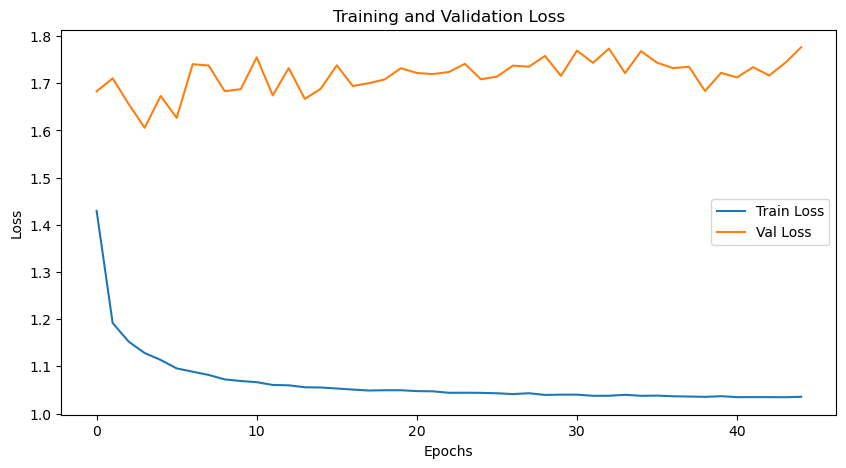

In [12]:
# Plotting training curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

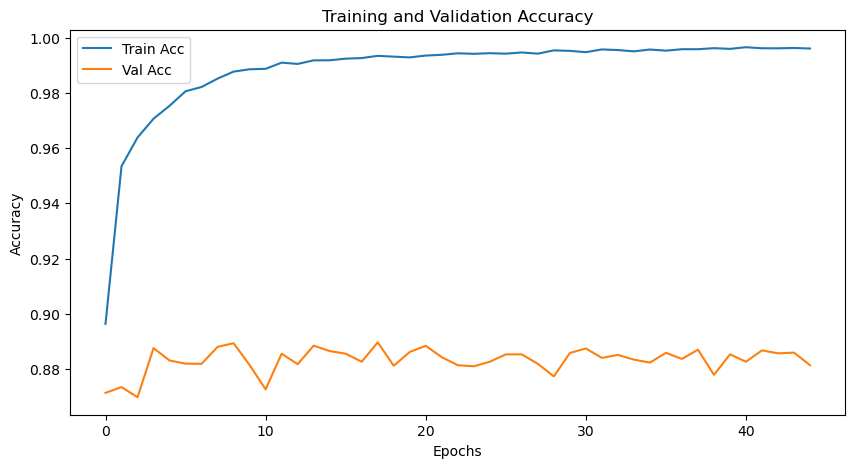

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [14]:
# Load best model
model.load_state_dict(torch.load('effnet_best_model.pth'))

<All keys matched successfully>

In [15]:
# Testing
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Overall Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Overall Accuracy: 0.9315
Precision: 0.9385
Recall: 0.9315
F1-score: 0.9299


In [16]:
print("train_loss_list = ",train_loss_list)
print("val_loss_list = ", val_loss_list)
print("train_acc_list = ",train_acc_list)
print("val_acc_list = ", val_acc_list)

train_loss_list =  [1.4295719125630746, 1.1919313416858848, 1.1523466688004995, 1.1282098580123787, 1.1135441013124376, 1.0955917874535361, 1.0885910942349013, 1.0817337242973686, 1.072276179400257, 1.0689232267348872, 1.0663785147763456, 1.0605231067084935, 1.059730874175209, 1.0556239450922449, 1.0551017007088648, 1.0530141579615304, 1.0507062475690958, 1.0487194926563614, 1.049302060732337, 1.0493201395898557, 1.0474573608903681, 1.0470313658391623, 1.0438955982962808, 1.0440486560604212, 1.0437540213037186, 1.042879211413095, 1.0411864166800309, 1.042964978256689, 1.0393712679866838, 1.0399361635095608, 1.0399800102582482, 1.0375368114562997, 1.03763044438933, 1.0395857648672984, 1.0375056350210488, 1.0379094194304124, 1.036534298286747, 1.0359679349520912, 1.0352776641443053, 1.0367107226574193, 1.0346623317157002, 1.0347365276740423, 1.0347015454356832, 1.0345101266875303, 1.0354436611150164]
val_loss_list =  [1.6828105237319884, 1.7103957818587299, 1.6560956741634167, 1.60556675